# Teaching an agent to play Blackjack using Monte Carlo Methods

In this notebook, I teach an agent to play Blackjack using differents Monte Carlo Methods as part of a mini project from [Machine Learning Engineer Nanodegree](https://eu.udacity.com/course/machine-learning-engineer-nanodegree--nd009) at [Udacity](https://eu.udacity.com/).

### Blackjack environment
Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over. They're playing against a fixed dealer.
- Face cards (Jack, Queen, King) have point value 10.
- Aces can either count as 11 or 1, and it's called 'usable' at 11.
- This game is placed with an infinite deck (or with replacement).
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).
- After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins.
- If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21. The reward for winning is +1, drawing is 0, and losing is -1.
- The observation of a 3-tuple of: the players current sum, the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).

### Part 0: Exploring BlackjackEnv

Creating an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```


In [2]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Part 1: MC Prediction: State Values

In this section, I have coded an alghorithm of MC prediction for estimating the state-value function.

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [3]:
def generate_episode_from_limit(bj_env):
    #############################################################
    # Generation of an episode using the policy described above #
    #############################################################
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Then, I implement a first-visit MC prediction. Although, in the case of the Blackjack environment, the techniques are equivalent.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.

In [4]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    #######################################
    # First-visit MC prediction algorithm #
    #######################################
    
    #<-Initialize empty dictionary of lists->#
    values = defaultdict(list)

    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        #<-Generate an episode->#
        episode = generate_episode(env)
        #<-Obtain env variables from episodes->#
        states, actions, rewards = zip(*episode)
        #<-Dicount values->#
        discounts_values = np.array([gamma**i for i in range(len(rewards)+1)])
        #<-Calculate and store the values for each visit in the episode->
        for i, state in enumerate(states):
            values[state].append(sum(rewards[i:]*discounts_values[:-(1+i)]))
    #<-Calculate the state-value function->#
    V= {k: np.mean(v) for k,v in values.items()}
    return V

The cell below to calculate and plot the state-value function estimate.

In [5]:
from plot_utils import plot_blackjack_values

#<-Obtain the value function->#
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

#<-Plot the value function->#
plot_blackjack_values(V)

Episode 500000/500000.

### Part 2: MC Prediction: Action Values

In this section, I have coded an alghorithm of MC prediction for estimating the action-value function.  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    #############################################################
    # Generation of an episode using the policy described above #
    #############################################################
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Then, I implement a first-visit MC prediction. Although, in the case of the Blackjack environment, the techniques are equivalent.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [7]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    #######################################
    # First-visit MC prediction algorithm #
    #######################################
    
    #<-Initialize empty dictionaries of arrays->#
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    #<-Loop over episodes->#
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        #<-Generate an episode->#
        episode = generate_episode(env)
        #<-Obtain env variables from episodes->#
        states, actions, rewards = zip(*episode)
        #<-Dicount values->#
        discounts_values = np.array([gamma**i for i in range(len(rewards)+1)])

        for i, state in enumerate(states):
            #<-Calculate and store the values for each visit in the episode->
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts_values[:-(1+i)])
            N[state][actions[i]] += 1.0
            #<-Calculate the action-value function->#
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
           
    return Q

The cell below obtains the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

Episode 500000/500000.

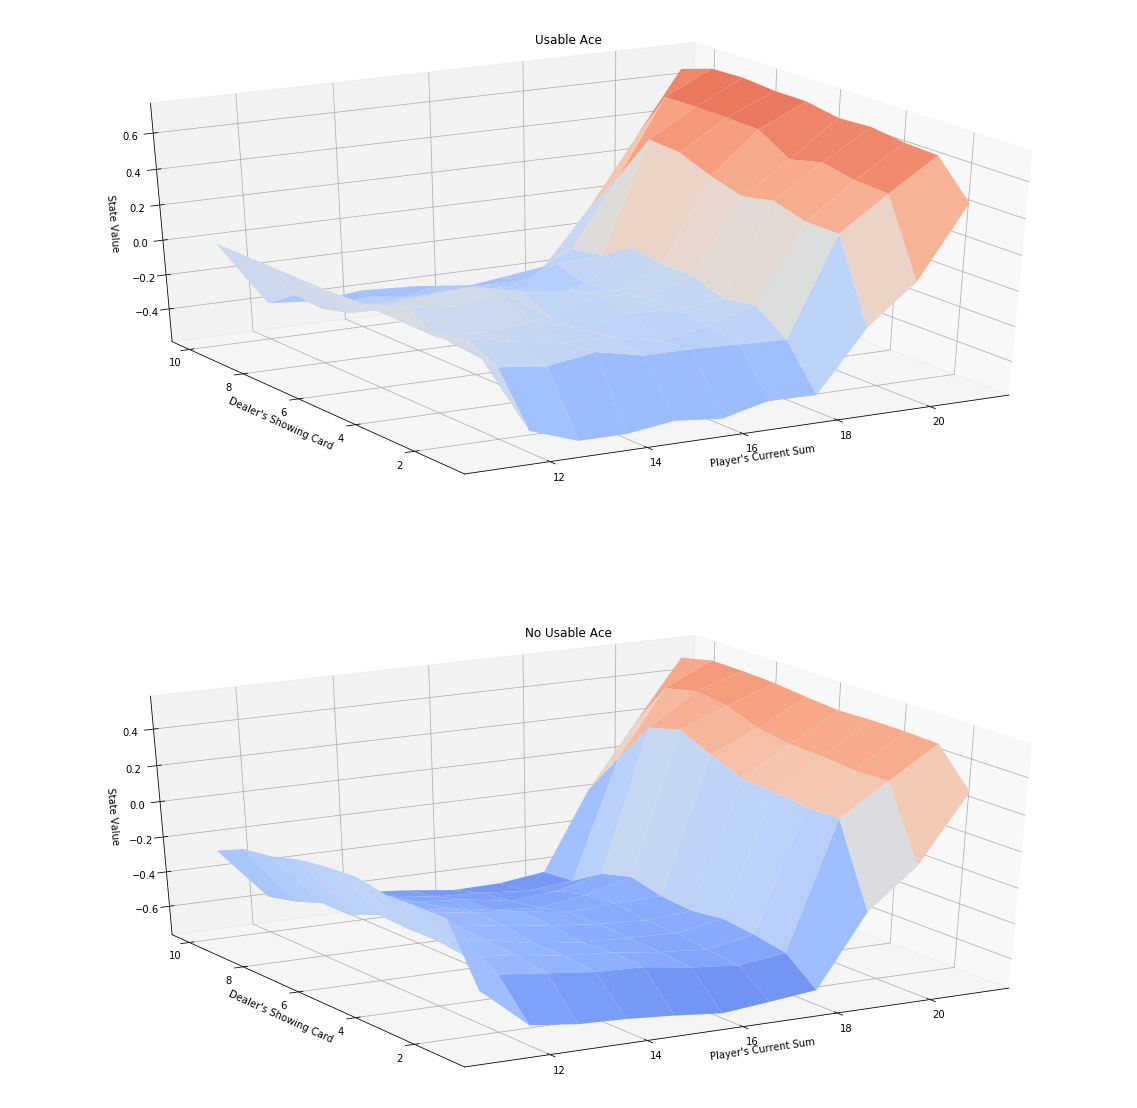

In [8]:
#<-Obtain the action-value function->#
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

#<-Obtain the state-value function->#
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

#<-Plot the state-value function->#
plot_blackjack_values(V_to_plot)

### Part 3: MC Control: GLIE

In this section, I have coded an alghorithm GLIE MC control.  

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.


In [9]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    #################################################################
    # Generates an episode from following the epsilon-greedy policy #
    #################################################################
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    ###########################################################################
    # Obtains the action probabilities corresponding to epsilon-greedy policy #
    ###########################################################################
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q_GLIE(env, episode, Q, N, gamma):
    ############################################################################
    # Updates the action-value function estimate using the most recent episode #
    ############################################################################
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
    return Q, N

In [10]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    #############################
    # GLIE MC control algorithm #
    #############################
    nA = env.action_space.n
    #<-Initialize empty dictionaries of arrays->#
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    #<-Loop over episodes->#
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        #<-Set the value of epsilon->#
        epsilon = 1.0/((i_episode/8000)+1)
        #<-Generate an episode by following epsilon-greedy policy->#
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        #<-Update the action-value function estimate using the episode->#
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
    #<-Determine the policy corresponding to the final action-value function estimate->#
    policy = dict((k,np.argmax(v)) for k, v in Q.items())        
    return policy, Q

In [11]:
#<-Obtain the estimated optimal policy and action-value function->#
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

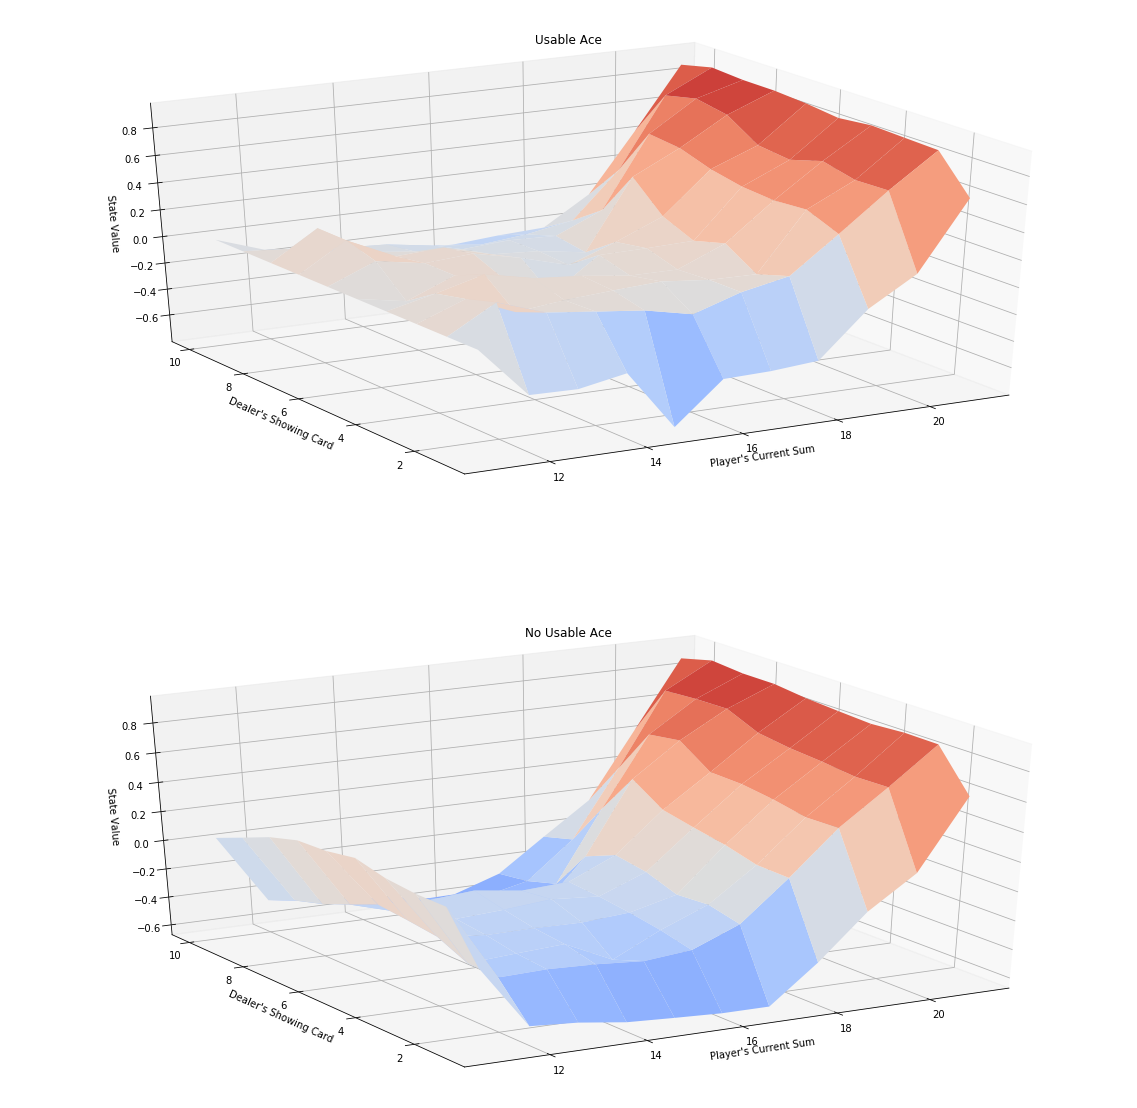

In [12]:
#<-Obtain the state-value function->#
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

#<-Plot the state-value function->#
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

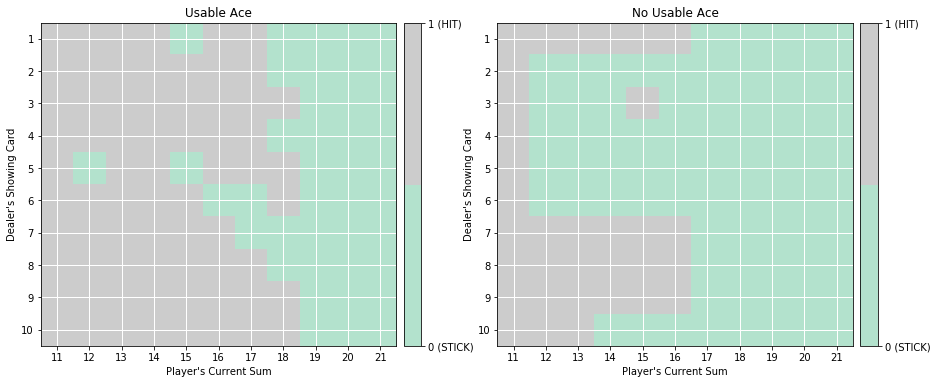

In [13]:
from plot_utils import plot_policy

#<-Plot the policy->#
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).

![True Optimal Policy](images/optimal.png)

### Part 4: MC Control: Constant-$\alpha$

In this section, I have coded an alghorithm of constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [14]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    ############################################################################
    # Updates the action-value function estimate using the most recent episode #
    ############################################################################
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [15]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    #######################################
    # Alpha-constant MC control algorithm #
    #######################################
    nA = env.action_space.n
    #<-Initialize empty dictionary of arrays->#
    Q = defaultdict(lambda: np.zeros(nA))
    #<-Loop over episodes->#
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        #<-Set the value of epsilon->#
        epsilon = 1.0/((i_episode/8000)+1)
        #<-Generate an episode by following epsilon-greedy policy->#
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        #<-Update the action-value function estimate using the episode->#
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
    #<-Determine the policy corresponding to the final action-value function estimate->
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [16]:
#<-Obtain the estimated optimal policy and action-value function->#
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

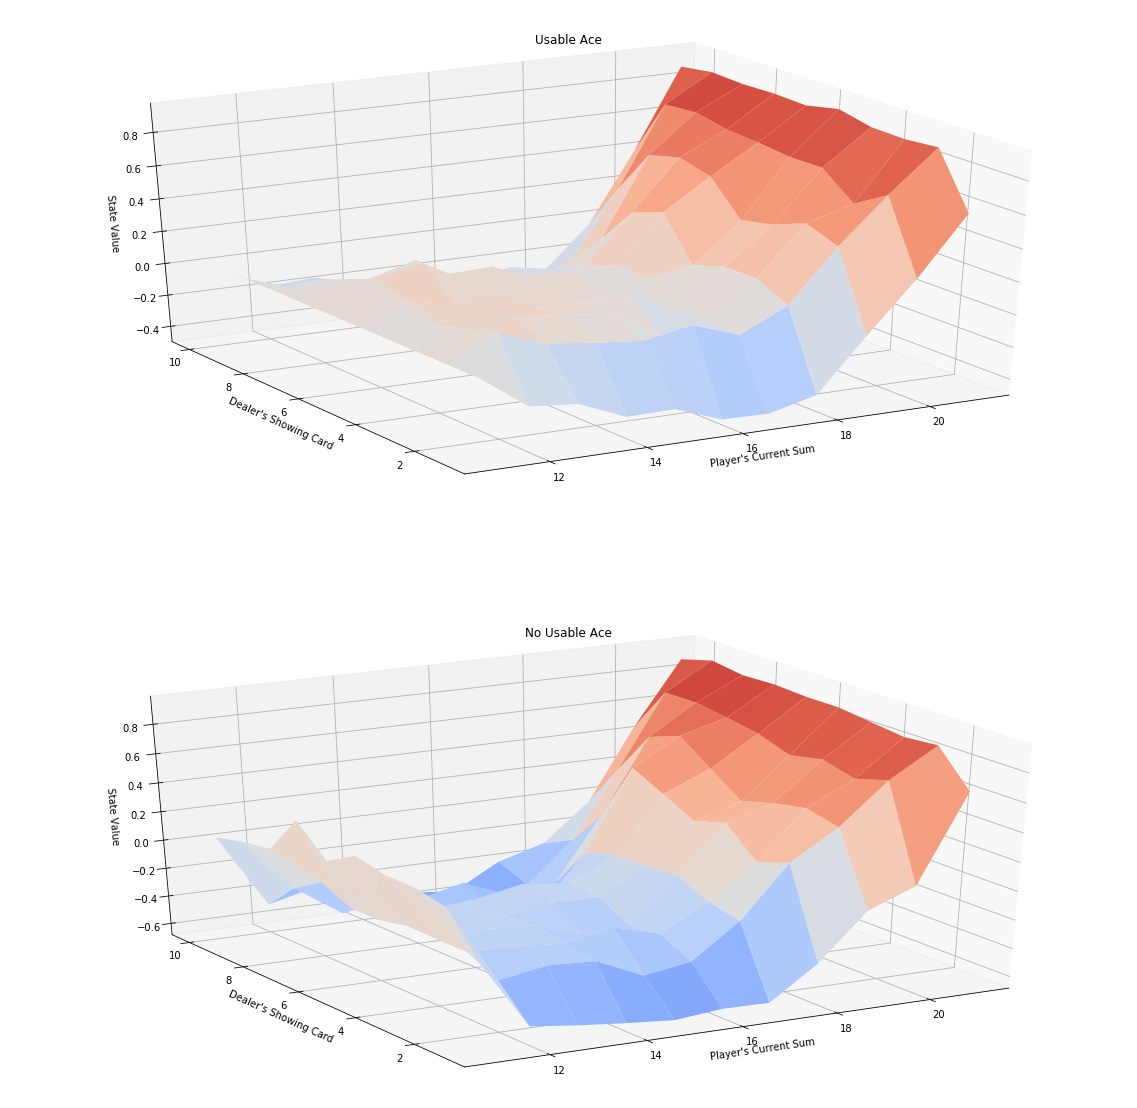

In [17]:
#<-Obtain the state-value function->#
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

#<-Plot the state-value function->#
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

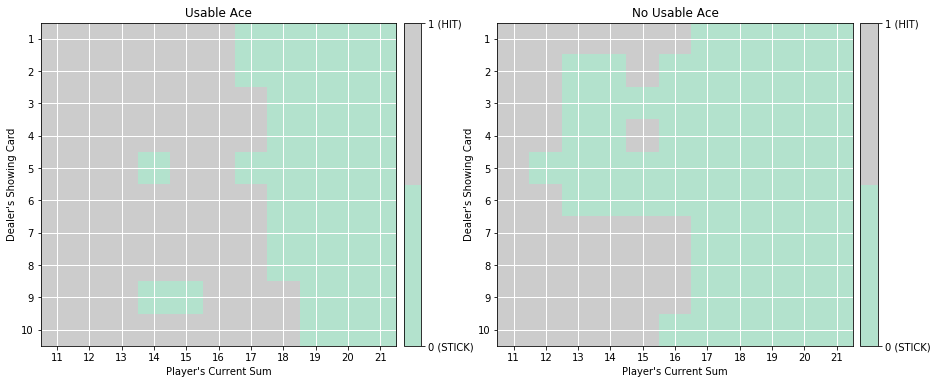

In [18]:
#<-Plot the policy->#
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).

![True Optimal Policy](images/optimal.png)